# What is the relationship between EPLs and penalty projects?
Author: Ryan Treves

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Suppress warning messages
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000

In [127]:
# Load data
data_path = '~/sherlock_oak/EPA/Data/manual/california/'
# This table comes from this report: https://ciwqs.waterboards.ca.gov/ciwqs/readOnly/penaltyProjectReport.xhtml?projectType=SEP%2CCP%2CECA of all penalty projects of type CP, ECA, or SEP
penalty_projects = pd.read_csv(data_path + 'PenaltyProjectReport.csv', parse_dates=['Order Effective Date'], date_parser= lambda t: pd.to_datetime(t, errors='coerce'))
enforcements = pd.read_csv(data_path + 'enf_actions_export.csv', dtype={'ENFORCEMENT ID (EID)': object}, parse_dates=['ACL ISSUANCE DATE', 'EPL ISSUANCE DATE', 'DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION'], date_parser= lambda t: pd.to_datetime(t, errors='coerce'))

First, select only EPLs from the list of enforcement actions

In [128]:
# EPL enforcement actions
epl_enforcements = enforcements[
                                # Either have a valid ACL issuance date and some mention of an EPL in the enforcement action
                                (((enforcements['ENFORCEMENT ACTION TYPE']=='Expedited Payment Letter') |
                              (enforcements['TITLE'].str.contains('Expedited Payment Letter')) |
                              (enforcements['TITLE'].str.contains('EPL'))) &
                              (~pd.isna(enforcements['ACL ISSUANCE DATE']))) |

                                # Or have a valid EPL issuance date
                                 (~(pd.isna(enforcements['EPL ISSUANCE DATE'])))
                 ]

# Filter out EPLs with no MMP violations
epl_enforcements = epl_enforcements[epl_enforcements['TOTAL MMP VIOLATIONS #']>0]

# Estimate the date the EPL was sent out
epl_enforcements['estimated_EPL_date'] = epl_enforcements[['EPL ISSUANCE DATE', 'ACL ISSUANCE DATE']].min(axis=1,
                                                                                                          skipna=True)

Link penalty projects to NPDES permit IDs using `FACILITY NAME` and the enforcements table:

Link penalty projects to EPLs by Project Location:

In [129]:
penalty_projects_merged = penalty_projects.merge(epl_enforcements, left_on='Project Location', right_on='FACILITY NAME', how='inner')[['Project Type', 'Order Effective Date', 'estimated_EPL_date', 'NPDES # CA#', 'Project Location']]
len(penalty_projects_merged)

134

134 penalty projects were linkable by location to an EPL.

In [130]:
penalty_projects_merged['Timing'] = penalty_projects_merged['Order Effective Date'] > penalty_projects_merged['estimated_EPL_date']
def define_timing(x):
    if x:
        return 'Order after EPL'
    else:
        return 'Order before EPL'
penalty_projects_merged['Timing'] = penalty_projects_merged['Timing'].apply(lambda x: define_timing(x))

Create an identifier for each unique Project Location x penalty project order combo

In [131]:
penalty_projects_merged['Project Location x Order Effective Date'] = penalty_projects_merged['Project Location'] + penalty_projects_merged['Order Effective Date'].astype(str)

Plot:

In [132]:
CPs = penalty_projects_merged[penalty_projects_merged['Project Type']=='CP']
SEPs = penalty_projects_merged[penalty_projects_merged['Project Type']=='SEP']
ECAs = penalty_projects_merged[penalty_projects_merged['Project Type']=='ECA']

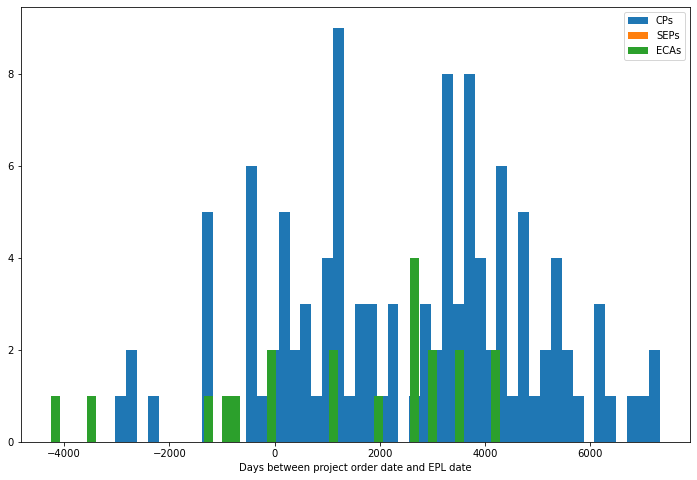

In [133]:
plt.figure(figsize=(12,8))
plt.hist((CPs['estimated_EPL_date'] - CPs['Order Effective Date']).dt.days, bins=50);
plt.hist((SEPs['estimated_EPL_date'] - SEPs['Order Effective Date']).dt.days, bins=50);
plt.hist((ECAs['estimated_EPL_date'] - ECAs['Order Effective Date']).dt.days, bins=50);
plt.xlabel('Days between project order date and EPL date')
plt.legend(['CPs', 'SEPs', 'ECAs'])

Another visualization of the same data:

In [ ]:
fig = px.timeline(CPs, x_start='Order Effective Date', x_end='estimated_EPL_date', y='Project Location x Order Effective Date', color='Timing', width=1000, height=800)
fig.update_yaxes(autorange="reversed")
fig.show()

(See <i> ca_mmp/policy_eval/CP_timelines.png)

![](../CP_timelines.png)

In [ ]:
fig = px.timeline(ECAs, x_start='Order Effective Date', x_end='estimated_EPL_date', y='Project Location x Order Effective Date', color='Timing')
fig.update_yaxes(autorange="reversed")
fig.show()

(See <i> ca_mmp/policy_eval/ECA_timelines.png)

![](../ECA_timelines.png)

In [136]:
pp_facilities = list(penalty_projects['Project Location'].unique())
epl_enforcements['Penalty Project Participant'] = epl_enforcements['FACILITY NAME'].apply(lambda x: x in pp_facilities)
def categorize_EPL(facility):
    cp_facilities = list(CPs['Project Location'].unique())
    ECAs_facilities = list(ECAs['Project Location'].unique())
    if facility in cp_facilities and facility not in ECAs_facilities:
        return 'CP'
    elif facility in ECAs_facilities and facility not in cp_facilities:
        return 'ECA'
    elif facility in cp_facilities and ECAs_facilities:
        return 'CP & ECA'
epl_enforcements['Penalty Project Type'] = epl_enforcements['FACILITY NAME'].apply(lambda x: categorize_EPL(x))

<AxesSubplot:xlabel='estimated_EPL_date', ylabel='DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION'>

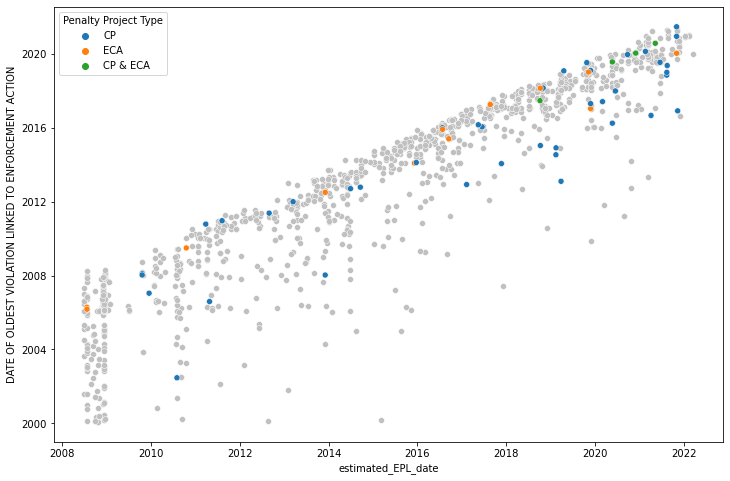

In [137]:
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.scatterplot('estimated_EPL_date', 'DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION', data=epl_enforcements[epl_enforcements['Penalty Project Participant']==False], color='silver')
sns.scatterplot('estimated_EPL_date', 'DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION', data=epl_enforcements[epl_enforcements['Penalty Project Participant']==True], hue='Penalty Project Type')

In [140]:
epl_enforcements['Penalty Project Type'].value_counts()

CP          40
ECA         12
CP & ECA     4
Name: Penalty Project Type, dtype: int64